In [1]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fatal: destination path 'AMPLify-Feedback' already exists and is not an empty directory.


In [2]:
generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')

In [3]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [4]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [15]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [37]:
species_vocal

array(['[UNK]', 'Bacillus_subtilis', 'Staphylococcus_aureus',
       'Escherichia_coli', 'Pseudomonas_aeruginosa', 'Candida_albicans',
       'Pectobacterium_carotovorum', 'Clavibacter_michiganensis',
       'Pseudomonas_corrugata', 'Pseudomonas_syringae',
       'Xanthomonas_vesicatoria', 'Klebsiella_pneumoniae',
       'Staphylococcus_epidermidis', 'Candida_parapsilosis',
       'Micrococcus_luteus', 'Enterococcus_faecium',
       'Enterobacter_cloacae', 'Acinetobacter_baumannii',
       'Bacillus_anthracis', 'Staphylococcus_saprophyticus',
       'Proteus_mirabilis', 'Proteus_vulgaris', 'Salmonella_typhimurium',
       'Saccharomyces_cerevisiae', 'Listonella_anguillarum',
       'Enterobacter_aerogenes', 'Providencia_stuartii',
       'Candida_tropicalis', 'Candida_krusei', 'Salmonella_enterica',
       'Streptococcus_pneumoniae', 'Shigella_sonnei',
       'Enterococcus_faecalis', 'Neisseria_gonorrhoeae',
       'Streptococcus_agalactiae', 'Malassezia_furfur',
       'Trichophyton_m

In [6]:
def onehot2seq(onehot):
    demo_seq = tf.math.argmax(onehot, axis=2)
    demo_seq = pep_decoder(demo_seq).numpy().astype('str')
    demo_seq = ["".join(chars) for chars in demo_seq]
    return demo_seq

In [41]:
# Grid search coordinates
num_bins = 101
labels = np.round(np.linspace(-1, 1, num_bins), 2)
noise = []
for x in labels:
    for y in labels:
        noise.append([x, y])
noise = np.array(noise)
num_sequences = len(noise)

# Look up the index of the target bacteria
target = 'Bacillus_subtilis'
bacteria = np.zeros(shape=(num_sequences, 326))
index = np.where(species_vocal==target)[0][0]
bacteria[:, index] = 1

# Generate sequences and predict MIC
generated_onehot = generator.predict(noise, verbose=0)
MIC = oracle.predict([generated_onehot, bacteria], verbose=0)
generated_sequences = onehot2seq(generated_onehot)
vis_data = np.concatenate([noise, np.array(generated_sequences).reshape(num_sequences, 1), MIC], axis=1)
vis_data = pd.DataFrame(vis_data, columns=["Noise_1", "Noise_2", "Peptide", "MIC"])
vis_data['MIC'] = vis_data['MIC'].astype('float64')
vis_data['Noise_1'] = vis_data['Noise_1'].astype('float64')
vis_data['Noise_2'] = vis_data['Noise_2'].astype('float64')

In [42]:
vis_data['Noise_1_bins'] = pd.cut(vis_data['Noise_1'], bins=num_bins, labels=labels)
vis_data['Noise_2_bins'] = pd.cut(vis_data['Noise_2'], bins=num_bins, labels=labels)

# Group the data by the bins and calculate the mean MIC
grouped = vis_data.groupby(['Noise_1_bins', 'Noise_2_bins'])
grid_mic_mean = grouped['MIC'].mean().reset_index()

# Pivot the results to create a grid that `sns.heatmap` can visualize
grid_mic_mean_pivot = grid_mic_mean.pivot('Noise_1_bins', 'Noise_2_bins', 'MIC')

<ipython-input-42-f0fb43b98688>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grid_mic_mean_pivot = grid_mic_mean.pivot('Noise_1_bins', 'Noise_2_bins', 'MIC')


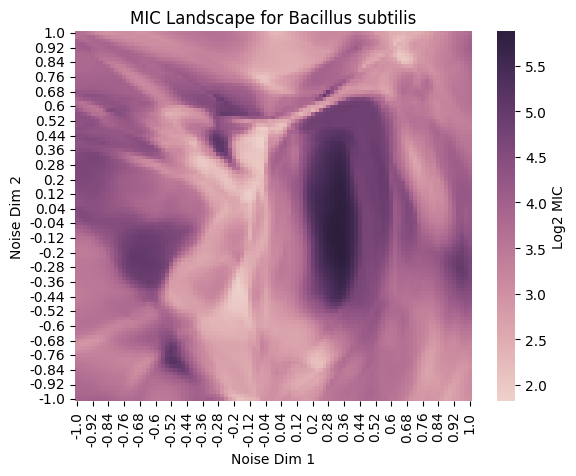

In [43]:
h = sns.heatmap(grid_mic_mean_pivot.transpose().iloc[::-1],
                cmap=sns.cubehelix_palette(as_cmap=True),
                cbar_kws={'label': 'Log2 MIC'})
h.set(xlabel="Noise Dim 1", ylabel="Noise Dim 2", title=f"MIC Landscape for {target.split('_')[0]} {target.split('_')[1]}")
plt.savefig(f"{target}.png", dpi=200, bbox_inches='tight')